In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR
from sklearn.svm import SVC
import scipy.stats as sp
from sklearn.model_selection import GridSearchCV as GS
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
from __future__ import division

In [2]:
def evaluateModel(prediction,actual):    
    prediction.plot(color='red', label='Prediction')
    actual.plot(color='blue', label='Actual')
    plt.legend(loc='best')
    prediction = np.array(prediction.tolist())
    actual = np.array(actual.tolist())
    print 'Pearson Correlation Coeefiecient: ', sp.pearsonr(actual, prediction)
    error2 = [((x-y)/y)**2 for x, y in zip(prediction, actual)]
    print "Normalised RMSE",np.sqrt(np.sum(error2))
    
def evaluateCls(prediction, actual, classes):
    trackright=0
    for x , y in zip(prediction, actual):
        if (x==y):
            trackright+=1    
    print 'Percentage that was right', trackright/len(actual)
    
    cm = confusion_matrix(prediction, actual)
    fig, ax = plt.subplots()
    im = ax.matshow(cm)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
    plt.title('Confusion matrix')
    fig.colorbar(im)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    print(classification_report(actual, prediction, target_names=classes))
    if(len(classes)<3):
        print 'Area under the curve (AUC) is:', roc_auc_score(actual, prediction)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, prediction)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        plt.title('Receiver Operating Characteristic')
        plt.plot(false_positive_rate, true_positive_rate, 'b',
        label='AUC = %0.2f'% roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1],[0,1],'r--')
        plt.xlim([-0.1,1.1])
        plt.ylim([-0.1,1.1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

In [3]:
msft = pd.DataFrame.from_csv('MSFT.csv')
msft = msft.interpolate()
#changing the index to go from 1986 to 2016
msft = msft.reindex(index=msft.index[::-1])
investor = pd.DataFrame.from_csv('investor.csv')
investor = investor.fillna(investor.mean())
#changing the index to go from 1987 to 2016
investor = investor.reindex(index=investor.index[::-1])

In [4]:
msft.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1986-03-13,25.50,29.25,25.5,28.00,3582600.0,0.0,1.0,0.060989,0.069957,0.060989,0.066968,1.031789e+09
1986-03-14,28.00,29.50,28.0,29.00,1070000.0,0.0,1.0,0.066968,0.070555,0.066968,0.069360,3.081600e+08
1986-03-17,29.00,29.75,29.0,29.50,462400.0,0.0,1.0,0.069360,0.071153,0.069360,0.070555,1.331712e+08
1986-03-18,29.50,29.75,28.5,28.75,235300.0,0.0,1.0,0.070555,0.071153,0.068164,0.068762,6.776640e+07
1986-03-19,28.75,29.00,28.0,28.25,166300.0,0.0,1.0,0.068762,0.069360,0.066968,0.067566,4.789440e+07


In [5]:
investor.head()

,Bullish,Neutral,Bearish,Total,Bullish 8-Week Mov Avg,Bull-Bear Spread,Bullish Average,Bullish Average + St. Dev,Bullish Average - St. Dev,S&P 500 Weekly High,S&P 500 Weekly Low,S&P 500 Weekly Close
Date,,,,,,,,,,,,
1987-06-26,0.384424,0.312702,0.302874,0.999999,0.384009,0.08155,0.386014,0.489178,0.28285,1038.23181,1011.831541,1026.840289
1987-07-17,0.384424,0.312702,0.302874,0.999999,0.384009,0.08155,0.386014,0.489178,0.28285,314.59000,307.630000,314.590000
1987-07-24,0.360000,0.500000,0.140000,1.000000,0.384009,0.22000,0.386014,0.489178,0.28285,311.39000,307.810000,309.270000
1987-07-31,0.260000,0.480000,0.260000,1.000000,0.384009,0.00000,0.386014,0.489178,0.28285,318.66000,310.650000,318.660000
1987-08-07,0.560000,0.150000,0.290000,1.000000,0.384009,0.27000,0.386014,0.489178,0.28285,323.00000,316.230000,323.000000


In [6]:
weekholder1 = investor.drop(investor.index[-1]).index
weekholder2 = investor.drop(investor.index[0]).index

In [7]:
Open = []
Close = []
High = []
Low = []
volume=[]
for week1, week2 in zip(weekholder1, weekholder2):
    Open.append(np.mean(msft.Open.loc[week1:week2]))
    Close.append(np.mean(msft.Close.loc[week1:week2]))
    High.append(np.mean(msft.High.loc[week1:week2]))
    Low.append(np.mean(msft.Low.loc[week1:week2]))
    volume.append(np.mean(msft['Adj. Volume'].loc[week1:week2]))

In [8]:
msftweek = pd.DataFrame(index=weekholder2, data={'Open': Open, "Close":Close, "High":High, "Low":Low, "Volume":volume})

In [9]:
cols = ['Open','Close','High','Low', 'Volume']
msftweek=msftweek[cols]
msftweek.head()

,Open,Close,High,Low,Volume
Date,,,,,
1987-07-17,100.133333,99.866667,101.783333,98.000000,80762880.0
1987-07-24,100.125000,99.541667,101.166667,98.291667,64905600.0
1987-07-31,98.666667,98.000000,99.416667,96.625000,67929600.0
1987-08-07,95.791667,96.875000,98.228333,94.500000,162134400.0
1987-08-14,102.208333,102.500000,103.833333,101.125000,78307200.0


In [10]:
sentiments = investor[['Bullish','Neutral','Bearish']]
sentiments = sentiments[1:]
sentiments.head()

,Bullish,Neutral,Bearish
Date,,,
1987-07-17,0.384424,0.312702,0.302874
1987-07-24,0.360000,0.500000,0.140000
1987-07-31,0.260000,0.480000,0.260000
1987-08-07,0.560000,0.150000,0.290000
1987-08-14,0.450000,0.350000,0.200000


In [11]:
trainData = sentiments[:(int)(len(sentiments)*0.8)]
testData = sentiments[(-(int)(len(sentiments)*0.2)):]
trainOutput = msftweek.Open[:(int)(len(sentiments)*0.8)]
testOutput = msftweek.Open[(-(int)(len(sentiments)*0.2)):]

In [12]:
UpDownCls = []
previousday=msftweek.Open[0]
for stock in msftweek.Open[1:]:    
    if (stock > previousday):
        UpDownCls.append(1)
    else:
        UpDownCls.append(-1)
    previousday = stock
UpDownCls = pd.Series(UpDownCls , index=msftweek.index[1:])
UpDownCls.head()

Date
1987-07-24   -1
1987-07-31   -1
1987-08-07   -1
1987-08-14    1
1987-08-21    1
dtype: int64

In [13]:
ClsFeatures = sentiments.loc[UpDownCls.index]

In [14]:
trainDataCls = ClsFeatures[:(int)(len(ClsFeatures)*0.8)]
testDataCls = ClsFeatures[(-(int)(len(ClsFeatures)*0.2)):]
trainOutputCls = UpDownCls[:(int)(len(ClsFeatures)*0.8)]
testOutputCls = UpDownCls[(-(int)(len(ClsFeatures)*0.2)):]

# SVR MODEL

In [15]:
SVRparams =[ {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100],
           'epsilon':[0.001, 0.01, 0.1, 1, 5, 10, 100],
           'kernel':[ 'linear', 'rbf'],
          'gamma':[0, 0.001, 0.01, 0.1, 1]},
         {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100],
           'epsilon':[0.001, 0.01, 0.1, 1, 5, 10, 100],
           'kernel':['poly', 'sigmoid'],
          'degree':[1, 2, 3, 4, 5],
          'coef0':[0, 0.001, 0.01, 0.1, 1],
          'gamma':[0, 0.001, 0.01, 0.1, 1]}
         ]


In [16]:
svrModel = SVR()
SVRgridsearch = GS(svrModel, param_grid=SVRparams, n_jobs=6)
SVRgridsearch.fit(trainData,trainOutput)
SVRgridsearch.best_params_

{'C': 100,
 'coef0': 1,
 'degree': 5,
 'epsilon': 0.001,
 'gamma': 1,
 'kernel': 'poly'}

In [23]:
svrModel = SVR()
SVRgridsearch = GS(svrModel, param_grid=SVRparams, n_jobs=6, scoring='r2')
SVRgridsearch.fit(trainData,trainOutput)
SVRgridsearch.best_params_

{'C': 100,
 'coef0': 1,
 'degree': 5,
 'epsilon': 0.001,
 'gamma': 1,
 'kernel': 'poly'}

In [69]:
svrModel = SVR(C= 100,
 coef0= 1,
 degree= 5,
 epsilon= 0.001,
 gamma= 1,
 kernel= 'poly')

In [83]:
svrModel.fit(trainData,trainOutput)

SVR(C=100, cache_size=200, coef0=1, degree=5, epsilon=0.001, gamma=1,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Pearson Correlation Coeefiecient:  (0.52892691585817642, 1.5638919187698032e-88)
Normalised RMSE 23.5011611479


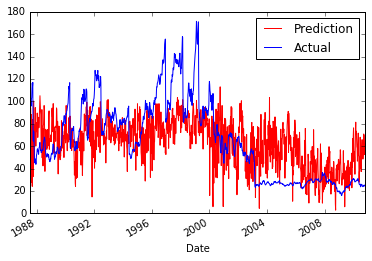

In [84]:
SVRresult = svrModel.predict(trainData)
SVRresult = pd.Series(SVRresult, trainOutput.index)
evaluateModel(SVRresult,trainOutput)

Pearson Correlation Coeefiecient:  (0.53633595341482632, 5.7433609063371331e-24)
Normalised RMSE 17.6382649631


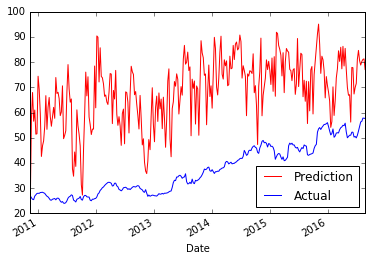

In [86]:
SVRresult = svrModel.predict(testData)
SVRresult = pd.Series(SVRresult, testOutput.index)
evaluateModel(SVRresult,testOutput)

# SVC Model

In [72]:
SVCparams =[ {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100],           
           'kernel':[ 'linear', 'rbf'],
          'gamma':[0, 0.001, 0.01, 0.1, 1]},
         {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100],
           'kernel':['poly', 'sigmoid'],
          'degree':[1, 2, 3, 4, 5],
          'coef0':[0, 0.001, 0.01, 0.1, 1],
          'gamma':[0, 0.001, 0.01, 0.1, 1]}
         ]

In [24]:
svcModel = SVC()
SVCgridsearch = GS(svcModel, param_grid=SVCparams, scoring='accuracy', n_jobs=6)
SVCgridsearch.fit(trainDataCls,trainOutputCls)
SVCgridsearch.best_params_

{'C': 100, 'coef0': 0.001, 'degree': 4, 'gamma': 1, 'kernel': 'poly'}

In [73]:
svcModel = SVC(C=100, coef0=0.001, degree=4, gamma=1, kernel='poly')

In [74]:
svcModel.fit(trainDataCls,trainOutputCls)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.001,
  decision_function_shape=None, degree=4, gamma=1, kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Percentage that was right 0.551070840198


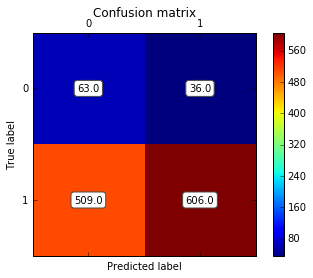

             precision    recall  f1-score   support

         -1       0.64      0.11      0.19       572
          1       0.54      0.94      0.69       642

avg / total       0.59      0.55      0.45      1214

Area under the curve (AUC) is: 0.527032546892


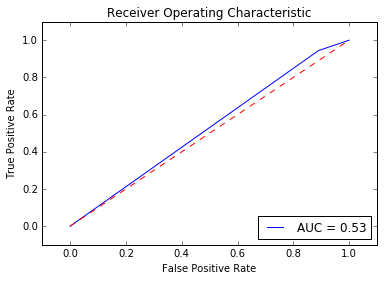

In [75]:
prediction = svcModel.predict(trainDataCls)
evaluateCls(prediction, trainOutputCls, ['-1', '1'])

Percentage that was right 0.597359735974


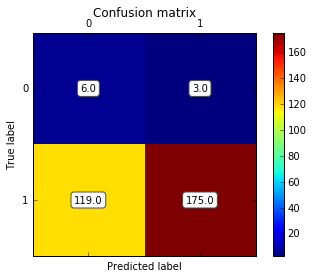

             precision    recall  f1-score   support

         -1       0.67      0.05      0.09       125
          1       0.60      0.98      0.74       178

avg / total       0.62      0.60      0.47       303

Area under the curve (AUC) is: 0.515573033708


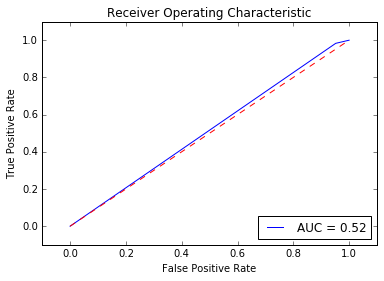

In [76]:
prediction = svcModel.predict(testDataCls)
evaluateCls(prediction, testOutputCls, ['-1', '1'])

# RFR Model

In [77]:
RFRparams =[ {'criterion':[ 'mae', 'mse'],
          'max_features':['auto', 'sqrt', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[False],
          'oob_score':[False],
          'min_samples_leaf':[1,2,3],
          'n_jobs':[6]},
         {'criterion':[ 'mae', 'mse'],
          'max_features':['auto', 'sqrt', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[True],
          'oob_score':[True],
          'min_samples_leaf':[1,2,3],
          'n_jobs':[6]} 
        ]


In [78]:
randomForestRegression = RFR()
RFRgridsearch = GS(randomForestRegression, param_grid=RFRparams)
RFRgridsearch.fit(trainData,trainOutput)
RFRgridsearch.best_params_

/home/chuanfuyap/Applications/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'bootstrap': True,
 'criterion': 'mae',
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_jobs': 6,
 'oob_score': True}

In [79]:
randomForestRegression = RFR(
 n_estimators=1000,
 bootstrap= True,
 criterion= 'mae',
 max_features= 'sqrt',
 min_samples_leaf= 3,
 min_samples_split= 2,
 n_jobs= 6,
 oob_score= True)

In [80]:
randomForestRegression.fit(trainData,trainOutput)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=6, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

Pearson Correlation Coeefiecient:  (0.8022914097772289, 4.4952122040105383e-274)
Normalised RMSE 15.1501233024


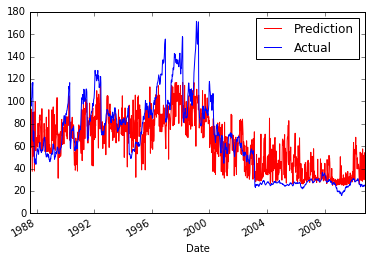

In [87]:
prediction = randomForestRegression.predict(trainData)
prediction = pd.Series(prediction, trainData.index)
evaluateModel(prediction,trainOutput)

Pearson Correlation Coeefiecient:  (0.44484963349010548, 3.9406113350828654e-16)
Normalised RMSE 16.2644669495


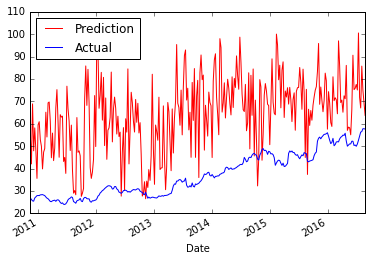

In [88]:
prediction = randomForestRegression.predict(testData)
prediction = pd.Series(prediction, testData.index)
evaluateModel(prediction,testOutput)

# RFC Model

In [ ]:
RFCparams =[ {'criterion':[ 'gini', 'entropy'],
          'max_features':['auto', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[False],
          'oob_score':[False],
          'min_samples_leaf':[1,2,3],
          'n_jobs':[6]},
         {'criterion':[ 'gini', 'entropy'],
          'max_features':['auto', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[True],
          'oob_score':[True],
          'min_samples_leaf':[1,2,3],
          'n_jobs':[6]} 
        ]


In [90]:
randomForestClassifier = RFC()
RFCgridsearch = GS(randomForestClassifier, param_grid=RFCparams)
RFCgridsearch.fit(trainDataCls,trainOutputCls)
RFCgridsearch.best_params_

/home/chuanfuyap/Applications/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'bootstrap': False,
 'criterion': 'gini',
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_jobs': 6,
 'oob_score': False}

In [91]:
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'gini',
 max_features= 'auto',
 min_samples_leaf= 2,
 min_samples_split= 2,
 n_jobs= 6,
 oob_score= False
    )

In [92]:
randomForestClassifier.fit(trainDataCls,trainOutputCls)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=6, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Percentage that was right 0.914332784185


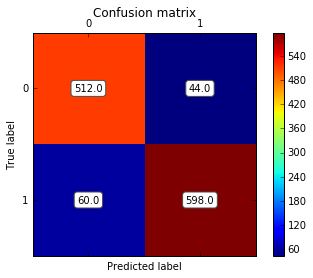

             precision    recall  f1-score   support

         -1       0.92      0.90      0.91       572
          1       0.91      0.93      0.92       642

avg / total       0.91      0.91      0.91      1214

Area under the curve (AUC) is: 0.91328453478


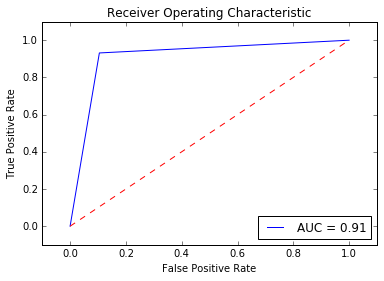

In [94]:
prediction = randomForestClassifier.predict(trainDataCls)
evaluateCls(prediction, trainOutputCls, ['-1', '1'])

Percentage that was right 0.544554455446


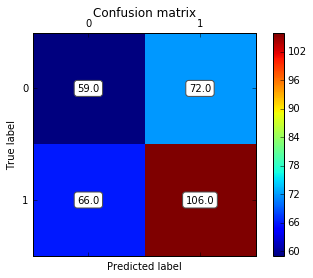

             precision    recall  f1-score   support

         -1       0.45      0.47      0.46       125
          1       0.62      0.60      0.61       178

avg / total       0.55      0.54      0.55       303

Area under the curve (AUC) is: 0.533752808989


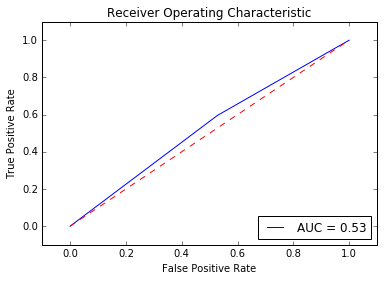

In [95]:
prediction = randomForestClassifier.predict(testDataCls)
evaluateCls(prediction, testOutputCls, ['-1', '1'])

# Restructured Data

In [14]:
weekholder = msftweek.index
investor = investor.loc[weekholder]
def makenewfeature(window, Series):
    name=Series.name
    index=[]
    mean=[]
    std=[]
    median=[]
    gradient=[]
    for count in range(len(weekholder)):
        frame=count+window
        if(frame<len(weekholder)):
            index.append(weekholder[frame])
            mean.append(np.mean(Series[count:frame]))
            std.append(np.std(Series[count:frame]))
            median.append(np.median(Series[count:frame]))
            gradient.append(np.mean(np.gradient(Series[count:frame])))
    df = pd.DataFrame(index=index, data={name+'_mean': mean, name+"_std":std, name+"_median":median, name+"_gradient":gradient})
    return df

In [15]:
statsOpen = makenewfeature(9, msftweek.Open)
statsBullish = makenewfeature(9, investor.Bullish)
statsNeutral = makenewfeature(9, investor.Neutral)
statsBearish = makenewfeature(9, investor.Bearish)
statsVolume = makenewfeature(9, msftweek.Volume)

In [13]:
frames = [statsOpen, statsBullish, statsNeutral, statsBearish]
newfeatures = pd.concat(frames, axis=1)
newfeatures.head()

,Open_gradient,Open_mean,Open_median,Open_std,Bullish_gradient,Bullish_mean,Bullish_median,Bullish_std,Neutral_gradient,Neutral_mean,Neutral_median,Neutral_std,Bearish_gradient,Bearish_mean,Bearish_median,Bearish_std
1987-09-18,1.304630,104.637037,102.208333,6.877166,0.015929,0.457158,0.45,0.111823,0.004550,0.294745,0.28,0.121980,-0.020479,0.248097,0.27,0.096415
1987-09-25,1.982870,106.501852,103.333333,7.636658,0.026667,0.481111,0.50,0.116661,-0.021111,0.292222,0.28,0.121818,-0.005556,0.226667,0.26,0.103064
1987-10-02,-6.444444,102.825926,103.333333,14.604782,0.042778,0.500000,0.52,0.109036,-0.059444,0.255556,0.23,0.101774,0.016667,0.244444,0.27,0.100345
1987-10-09,-3.254630,99.034259,103.333333,18.969834,-0.024444,0.520000,0.52,0.074087,0.028333,0.231111,0.23,0.064540,-0.003889,0.248889,0.29,0.101811
1987-10-16,-2.629630,96.557407,103.333333,20.615426,0.013889,0.508889,0.50,0.074751,0.007778,0.257778,0.26,0.074353,-0.021667,0.233333,0.27,0.104987


In [17]:
expected = msftweek.loc[newfeatures.index]
expected.head()

,Open,Close,High,Low,Volume
1987-09-18,116.916667,116.855000,118.250000,115.208333,5.556000e+07
1987-09-25,67.041667,68.208333,69.936667,66.500000,8.463253e+07
1987-10-02,64.541667,66.250000,67.270000,64.228333,9.665920e+07
1987-10-09,73.500000,73.666667,75.958333,71.396667,1.392453e+08
1987-10-16,71.791667,70.500000,74.041667,69.458333,1.268613e+08


In [19]:
trainData = newfeatures[:(int)(len(newfeatures)*0.8)]
testData = newfeatures[(-(int)(len(newfeatures)*0.2)):]
trainOutput = expected.Open[:(int)(len(newfeatures)*0.8)]
testOutput = expected.Open[(-(int)(len(newfeatures)*0.2)):]

# RFR

In [26]:
RFRparams =[ {'criterion':[ 'mae', 'mse'],
          'max_features':['auto', 'sqrt', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[False],
          'oob_score':[False],
          'min_samples_leaf':[1,2,3],
          'n_jobs':[6]},
         {'criterion':[ 'mae', 'mse'],
          'max_features':['auto', 'sqrt', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[True],
          'oob_score':[True],
          'min_samples_leaf':[1,2,3],
          'n_jobs':[6]} 
        ]

In [21]:
randomForestRegression = RFR()
RFRgridsearch = GS(randomForestRegression, param_grid=RFRparams, scoring='neg_mean_squared_error')
RFRgridsearch.fit(trainData,trainOutput)
RFRgridsearch.best_params_

/home/chuanfuyap/Applications/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'bootstrap': False,
 'criterion': 'mae',
 'max_features': 'auto',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_jobs': 6,
 'oob_score': False}

In [22]:
randomForestRegression = RFR(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'mae',
 max_features= 'auto',
 min_samples_leaf= 3,
 min_samples_split= 2,
 n_jobs= 6,
 oob_score= False)

In [23]:
randomForestRegression.fit(trainData,trainOutput)

RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=6, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Pearson Correlation Coeefiecient:  (0.99558589998829139, 0.0)
Normalised RMSE 1.78578796193


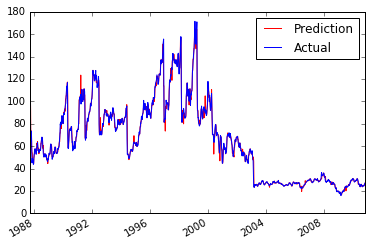

In [24]:
prediction = randomForestRegression.predict(trainData)
prediction = pd.Series(prediction, trainData.index)
evaluateModel(prediction,trainOutput)

Pearson Correlation Coeefiecient:  (0.78636705319033129, 1.0288424480754055e-64)
Normalised RMSE 2.88914292062


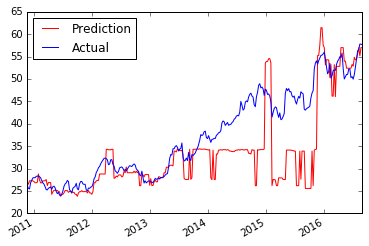

In [26]:
prediction = randomForestRegression.predict(testData)
prediction = pd.Series(prediction, testData.index)
evaluateModel(prediction,testOutput)

In [28]:
UpDownCls=UpDownCls[newfeatures.index]

In [31]:
trainDataCls = newfeatures[:(int)(len(newfeatures)*0.8)]
testDataCls = newfeatures[(-(int)(len(newfeatures)*0.2)):]
trainOutputCls = UpDownCls[:(int)(len(newfeatures)*0.8)]
testOutputCls = UpDownCls[(-(int)(len(newfeatures)*0.2)):]

# RFC

In [24]:
RFCparams =[ {'criterion':[ 'gini', 'entropy'],
          'max_features':['auto', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[False],
          'oob_score':[False],
          'min_samples_leaf':[1,2,3],
          'n_jobs':[6]},
         {'criterion':[ 'gini', 'entropy'],
          'max_features':['auto', 'log2'],
          'min_samples_split':[2,3],
          'bootstrap':[True],
          'oob_score':[True],
          'min_samples_leaf':[1,2,3],
          'n_jobs':[6]} 
        ]

In [33]:
randomForestClassifier = RFC()
RFCgridsearch = GS(randomForestClassifier, param_grid=RFCparams)
RFCgridsearch.fit(trainDataCls,trainOutputCls)
RFCgridsearch.best_params_

/home/chuanfuyap/Applications/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'bootstrap': False,
 'criterion': 'entropy',
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_jobs': 6,
 'oob_score': False}

In [34]:
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'entropy',
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_jobs= 6,
 oob_score= False
    )

In [35]:
randomForestClassifier.fit(trainDataCls,trainOutputCls)

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=6,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Percentage that was right 1.0


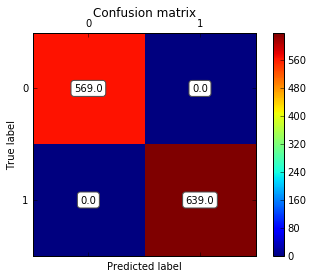

             precision    recall  f1-score   support

         -1       1.00      1.00      1.00       569
          1       1.00      1.00      1.00       639

avg / total       1.00      1.00      1.00      1208

Area under the curve (AUC) is: 1.0


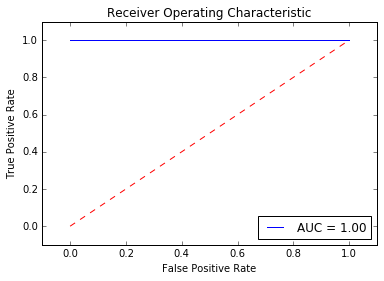

In [36]:
prediction = randomForestClassifier.predict(trainDataCls)
evaluateCls(prediction, trainOutputCls, ['-1', '1'])

Percentage that was right 0.556291390728


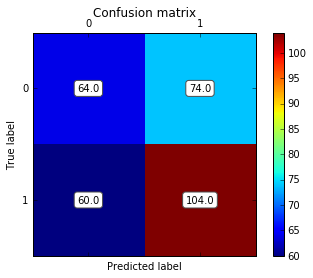

             precision    recall  f1-score   support

         -1       0.46      0.52      0.49       124
          1       0.63      0.58      0.61       178

avg / total       0.56      0.56      0.56       302

Area under the curve (AUC) is: 0.55019934759


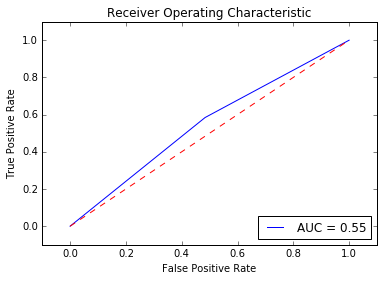

In [37]:
prediction = randomForestClassifier.predict(testDataCls)
evaluateCls(prediction, testOutputCls, ['-1', '1'])

# new class

In [31]:
Cls = []
previousday=msftweek.Open[0]
previousclose = msftweek.Close[0]
for op, cl in zip(msftweek.Open[1:], msftweek.Close[1:]):   
    if ((op > previousday) & (previousday<previousclose)):
        Cls.append(2)
    elif (op>cl):
        Cls.append(1)
    elif(op<cl):
        Cls.append(3)
    elif(op==cl):
        Cls.append(2)
    previousday = op
    previousclose = cl

In [32]:
Cls = pd.Series(Cls , index=msftweek.index[1:])
Cls=Cls[newfeatures.index]

In [33]:
trainCls = Cls[:(int)(len(newfeatures)*0.8)]
testCls = Cls[(-(int)(len(newfeatures)*0.2)):]

In [42]:
randomForestClassifier = RFC()
RFCgridsearch = GS(randomForestClassifier, param_grid=RFCparams)
RFCgridsearch.fit(trainDataCls,trainCls)
RFCgridsearch.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_jobs': 6,
 'oob_score': False}

In [43]:
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'gini',
 max_features= 'auto',
 min_samples_leaf= 3,
 min_samples_split= 3,
 n_jobs= 6,
 oob_score= False
    )

In [45]:
randomForestClassifier.fit(trainDataCls,trainCls)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=6, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Percentage that was right 1.0


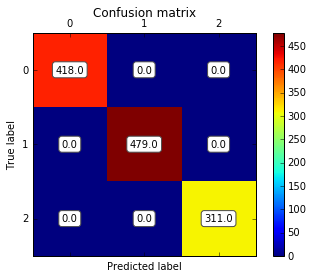

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       418
          2       1.00      1.00      1.00       479
          3       1.00      1.00      1.00       311

avg / total       1.00      1.00      1.00      1208



In [49]:
prediction = randomForestClassifier.predict(trainDataCls)
evaluateCls(prediction, trainCls, ['1', '2','3'])

Percentage that was right 0.417218543046


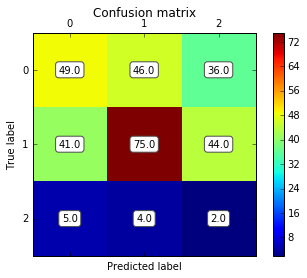

             precision    recall  f1-score   support

          1       0.37      0.52      0.43        95
          2       0.47      0.60      0.53       125
          3       0.18      0.02      0.04        82

avg / total       0.36      0.42      0.37       302



In [50]:
prediction = randomForestClassifier.predict(testDataCls)
evaluateCls(prediction, testCls, ['1', '2','3'])

# Volume included

In [16]:
frames = [statsOpen, statsBullish, statsNeutral, statsBearish, statsVolume]
newfeatures = pd.concat(frames, axis=1)
newfeatures.head()

,Open_gradient,Open_mean,Open_median,Open_std,Bullish_gradient,Bullish_mean,Bullish_median,Bullish_std,Neutral_gradient,Neutral_mean,Neutral_median,Neutral_std,Bearish_gradient,Bearish_mean,Bearish_median,Bearish_std,Volume_gradient,Volume_mean,Volume_median,Volume_std
1987-09-18,1.304630,104.637037,102.208333,6.877166,0.015929,0.457158,0.45,0.111823,0.004550,0.294745,0.28,0.121980,-0.020479,0.248097,0.27,0.096415,-4.243893e+06,8.455253e+07,78307200.0,3.119541e+07
1987-09-25,1.982870,106.501852,103.333333,7.636658,0.026667,0.481111,0.50,0.116661,-0.021111,0.292222,0.28,0.121818,-0.005556,0.226667,0.26,0.103064,-1.168373e+06,8.175221e+07,67929600.0,3.251327e+07
1987-10-02,-6.444444,102.825926,103.333333,14.604782,0.042778,0.500000,0.52,0.109036,-0.059444,0.255556,0.23,0.101774,0.016667,0.244444,0.27,0.100345,8.704622e+06,8.394409e+07,78307200.0,3.196397e+07
1987-10-09,-3.254630,99.034259,103.333333,18.969834,-0.024444,0.520000,0.52,0.074087,0.028333,0.231111,0.23,0.064540,-0.003889,0.248889,0.29,0.101811,-1.126394e+07,8.713627e+07,81777600.0,3.163816e+07
1987-10-16,-2.629630,96.557407,103.333333,20.615426,0.013889,0.508889,0.50,0.074751,0.007778,0.257778,0.26,0.074353,-0.021667,0.233333,0.27,0.104987,7.854667e+06,8.459304e+07,81777600.0,2.590835e+07


In [18]:
expected = msftweek.loc[newfeatures.index]
expected.head()

,Open,Close,High,Low,Volume
1987-09-18,116.916667,116.855000,118.250000,115.208333,5.556000e+07
1987-09-25,67.041667,68.208333,69.936667,66.500000,8.463253e+07
1987-10-02,64.541667,66.250000,67.270000,64.228333,9.665920e+07
1987-10-09,73.500000,73.666667,75.958333,71.396667,1.392453e+08
1987-10-16,71.791667,70.500000,74.041667,69.458333,1.268613e+08


In [28]:
trainData = newfeatures[:(int)(len(newfeatures)*0.8)]
testData = newfeatures[(-(int)(len(newfeatures)*0.2)):]
trainOutput = expected.Open[:(int)(len(newfeatures)*0.8)]
testOutput = expected.Open[(-(int)(len(newfeatures)*0.2)):]
trainDataCls = newfeatures[:(int)(len(newfeatures)*0.8)]
testDataCls = newfeatures[(-(int)(len(newfeatures)*0.2)):]
UpDownCls = UpDownCls.loc[newfeatures.index]
trainOutputCls = UpDownCls[:(int)(len(newfeatures)*0.8)]
testOutputCls = UpDownCls[(-(int)(len(newfeatures)*0.2)):]

In [27]:
randomForestRegression = RFR()
RFRgridsearch = GS(randomForestRegression, param_grid=RFRparams, scoring='neg_mean_squared_error')
RFRgridsearch.fit(trainData,trainOutput)
RFRgridsearch.best_params_

/home/chuanfuyap/Applications/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


{'bootstrap': True,
 'criterion': 'mae',
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_jobs': 6,
 'oob_score': True}

In [20]:
randomForestRegression = RFR(
 n_estimators=1000,
 bootstrap= True,
 criterion= 'mae',
 max_features= 'auto',
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_jobs= 6,
 oob_score= True)

In [21]:
randomForestRegression.fit(trainData,trainOutput)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=6, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

Pearson Correlation Coeefiecient:  (0.99835192889575408, 0.0)
Normalised RMSE 0.954760767692


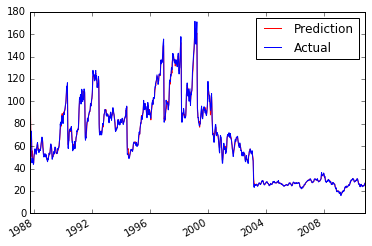

In [22]:
prediction = randomForestRegression.predict(trainData)
prediction = pd.Series(prediction, trainData.index)
evaluateModel(prediction,trainOutput)

Pearson Correlation Coeefiecient:  (0.8499406898495615, 1.7627494806540643e-85)
Normalised RMSE 2.52057131689


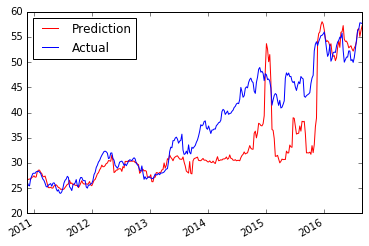

In [23]:
prediction = randomForestRegression.predict(testData)
prediction = pd.Series(prediction, testData.index)
evaluateModel(prediction,testOutput)

In [36]:
randomForestClassifier = RFC()
RFCgridsearch = GS(randomForestClassifier, param_grid=RFCparams, scoring='accuracy')
RFCgridsearch.fit(trainDataCls,trainOutputCls)
RFCgridsearch.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_jobs': 6,
 'oob_score': False}

In [37]:
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'gini',
 max_features= 'log2',
 min_samples_leaf= 3,
 min_samples_split= 2,
 n_jobs= 6,
 oob_score= False
    )

In [38]:
randomForestClassifier.fit(trainDataCls,trainOutputCls)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=6, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Percentage that was right 1.0


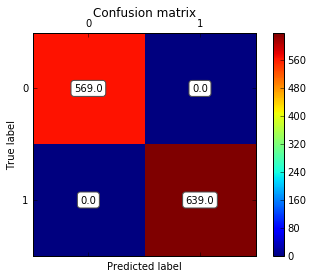

             precision    recall  f1-score   support

         -1       1.00      1.00      1.00       569
          1       1.00      1.00      1.00       639

avg / total       1.00      1.00      1.00      1208

Area under the curve (AUC) is: 1.0


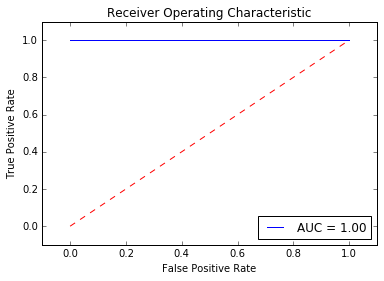

In [39]:
prediction = randomForestClassifier.predict(trainDataCls)
evaluateCls(prediction, trainOutputCls, ['-1', '1'])

Percentage that was right 0.562913907285


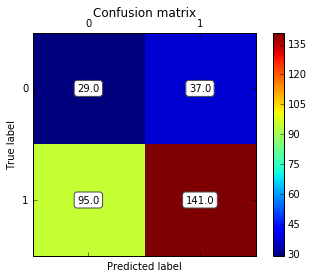

             precision    recall  f1-score   support

         -1       0.44      0.23      0.31       124
          1       0.60      0.79      0.68       178

avg / total       0.53      0.56      0.53       302

Area under the curve (AUC) is: 0.513002899601


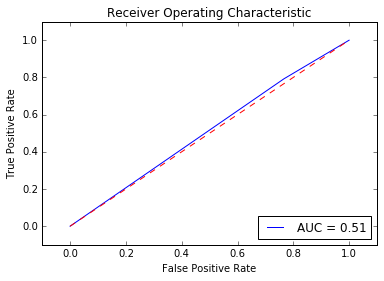

In [40]:
prediction = randomForestClassifier.predict(testDataCls)
evaluateCls(prediction, testOutputCls, ['-1', '1'])

In [41]:
randomForestClassifier = RFC()
RFCgridsearch = GS(randomForestClassifier, param_grid=RFCparams, scoring='accuracy')
RFCgridsearch.fit(trainDataCls,trainCls)
RFCgridsearch.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'n_jobs': 6,
 'oob_score': False}

In [42]:
randomForestClassifier = RFC(
 n_estimators=1000,
 bootstrap= False,
 criterion= 'gini',
 max_features= 'log2',
 min_samples_leaf= 3,
 min_samples_split= 3,
 n_jobs= 6,
 oob_score= False
    )

In [44]:
randomForestClassifier.fit(trainDataCls,trainCls)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=6, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Percentage that was right 1.0


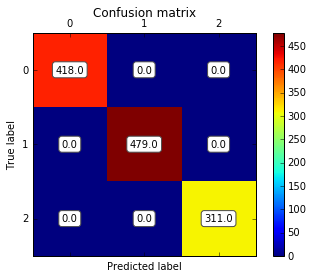

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       418
          2       1.00      1.00      1.00       479
          3       1.00      1.00      1.00       311

avg / total       1.00      1.00      1.00      1208



In [45]:
prediction = randomForestClassifier.predict(trainDataCls)
evaluateCls(prediction, trainCls, ['1', '2','3'])

Percentage that was right 0.407284768212


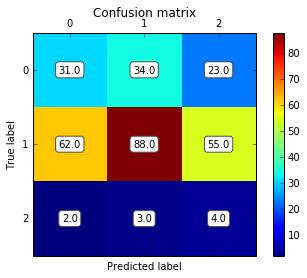

             precision    recall  f1-score   support

          1       0.35      0.33      0.34        95
          2       0.43      0.70      0.53       125
          3       0.44      0.05      0.09        82

avg / total       0.41      0.41      0.35       302



In [48]:
prediction = randomForestClassifier.predict(testDataCls)
evaluateCls(prediction, testCls, ['1', '2','3'])